# Нейросеть для рисование улыбки на портретах неулыбающихся лиц

Пока что не удалось достичь желаемой точности, упираюсь в размеры найденного датасета и ограничения на вычеслительные ресурсы Colab, дооубчение требует настройки оптимизаторов

# Подготовка данных
Списки аугментированных изображений:

faces, test_faces - не размеченные изображения лиц формата numpy

smile, nosmile - изображения улыбающихся и не улыбающихся лиц (с аугментацией)

data, label - объеденение списков smile и nosmile и список их меток

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os,random
import keras, signal
import numpy as np
from keras.optimizers import RMSprop
import pandas as pd
from keras.losses import mean_squared_error, categorical_crossentropy
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, AveragePooling2D, Dense, add, Concatenate, Flatten, UpSampling2D, Reshape, LeakyReLU, Input, Lambda, Conv2DTranspose, concatenate, multiply,Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from PIL import Image, ImageFilter
%matplotlib inline
path = 'drive/MyDrive/Colab Notebooks/MakeSmile/'
path0 = 'drive/MyDrive/Colab Notebooks/people segmentation/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_img(img):
    plt.figure(figsize=(14, 7))
    ax = plt.subplot(2, 1, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
def plot_images(x_data, pred, n=5):
    plt.figure(figsize=(14, 7))
    for i in range(1, n + 1):
        #index = np.random.randint(0, pred.shape[0])
        ax = plt.subplot(2, n, i)
        plt.imshow(x_data[i-1].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + n)
        plt.imshow(pred[i-1].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
faces=[]
age = []
print(len(os.listdir(path0+'row_faces/dataset')))
for k,i in enumerate(os.listdir(path0+'row_faces/dataset')[:6500]):
    img = Image.open(path0+'row_faces/dataset/'+i).resize((64,64))
    if k%5 == 0:
      img = img.convert('L').convert('RGB')
    if k%2==0:
      img = img.rotate(60*random.random()-30)
    img = np.array(img).astype('float32')
    faces.append(img/np.max(img))
    if k%1000==0 or k==100:
      print(k, end=' ')
print()
test_faces = faces[:200]
faces = faces[200:]
faces = np.array(faces)
test_faces = np.array(test_faces)
print(faces.shape,test_faces.shape)

11505
0 100 1000 2000 3000 4000 5000 6000 
(6300, 64, 64, 3) (200, 64, 64, 3)


In [ ]:
smile=[]
label = []
nosmile = []
for k,i in enumerate(os.listdir(path+'smile')):
  try:
    img = Image.open(path+'smile/'+i).resize((64,64))
  except: continue
  if k%2 == 0:
    imgwb = img.convert('L').convert('RGB')
    smile.append(np.array(imgwb).astype('float32')/255)
  imgrot = img.rotate(60*random.random()-30)
  smile.append(np.array(imgrot).astype('float32')/255)
  smile.append(np.array(img).astype('float32')/255)
  smile.append(np.array(img).astype('float32')[:,::-1]/255)

for k,i in enumerate(os.listdir(path+'non_smile')):
  try:
      img = Image.open(path+'non_smile/'+i).resize((64,64))
  except:pass
  if k%2 == 0:
    imgwb = img.convert('L').convert('RGB')
    nosmile.append(np.array(imgwb).astype('float32')/255)
  imgrot = img.rotate(60*random.random()-30)
  nosmile.append(np.array(imgrot).astype('float32')/255)
  nosmile.append(np.array(img).astype('float32')/255)
  nosmile.append(np.array(img).astype('float32')[:,::-1]/255)

print()
label = [1]*len(smile)+[0]*len(nosmile)
data = smile+nosmile
label,data = shuffle(label,data)
test_data = data[:200]
test_label = label[:200]
label = label[200:]
label = np.array(label)
data = data[200:]
test_data = np.array(test_data)

data = np.array(data)
label = np.array(label)
smile = np.array(smile)
nosmile =np.array(nosmile)
print(smile.shape,nosmile.shape,label.shape,data.shape)


(2100, 64, 64, 3) (2121, 64, 64, 3) (4021,) (4021, 64, 64, 3)


# Тренировка

сверточный дискриминатор

In [ ]:
def create_discriminator(in_shape):
    img_input1 = Input(in_shape) # 64*64*3
    eyes = Conv2D(32,(3,3),padding='same')(img_input1)
    #eyes = Dropout(0.2)(eyes)
    eyes = MaxPooling2D()(eyes)
    eyes = Conv2D(64,(3,3),padding = 'same')(eyes)
    eyes = MaxPooling2D()(eyes)
    eyes = Conv2D(128,(3,3),padding = 'same')(eyes)
    eyes = MaxPooling2D()(eyes) # 8*8*16
    eyes = Conv2D(256,(3,3),padding = 'same')(eyes)
    eyes = Conv2D(32,(3,3),padding = 'same')(eyes)
    eyes = Flatten()(eyes)

    x = Dense(16)(eyes)
    x = Dense(1,activation='sigmoid')(x)
    #x = Dropout(0.5)(x)
    model = Model(img_input1,x,name='dis')
    model.compile(loss='binary_crossentropy', metrics = 'accuracy')
    return model
#utils.plot_model(model,dpi=70,show_shapes=True)
discriminator = create_discriminator((64,64,3))
print(sum([np.array(i).reshape(-1).shape[0] for i in discriminator.weights]))

494977


Сверточный генератор с архитектурой автоэнкодера, выход которого связан с оригинальным изображением для восстановления точности (U-net).

Сначала сделал два выхода для обучения: главный выход и выход для неточного изображения автоэнкодера, впоследствии пользовался только главным выходом

In [ ]:
def create_generator(in_shape):
    img_input1 = Input(in_shape) # 64*64*3
    x64 = Conv2D(32,(3,3),padding='same')(img_input1)
    x64 = BatchNormalization()(x64)
    x32 = MaxPooling2D()(x64)
    x32 = Conv2D(64,(3,3),padding='same')(x32)
    x32 = BatchNormalization()(x32)
    x16 = MaxPooling2D()(x32)
    x16 = Conv2D(128,(3,3),padding='same')(x16)
    x16 = BatchNormalization()(x16)
    x8 = MaxPooling2D()(x16)
    x8 = Conv2D(256,(3,3),padding='same')(x8)
    x8 = Conv2D(32,(3,3),padding='same')(x8)


    x = Conv2DTranspose(32,(3,3),padding='same',strides=(2,2))(x8)
    x = Conv2DTranspose(32,(3,3),padding='same',strides=(2,2))(x)
    x = Conv2DTranspose(64,(3,3),padding='same',strides=(2,2))(x) # 64*64*64
    x1 = Conv2D(3,(3,3),padding='same',activation='sigmoid',name='base')(x)
    x64 = Conv2D(64,(8,8),padding='same')(x64)

    x64 = Concatenate(axis=-1)([x,x64])
    x64 = Conv2D(64,(3,3),padding='same')(x64)
    x64 = Conv2D(64,(3,3),padding='same')(x64)

    x0 = Conv2D(3,(3,3),padding='same',activation='sigmoid',name='target')(x64)

    model = Model(img_input1,[x0,x1],name='gen')
    model.compile(loss='mse',optimizer='adam')
    return model
gen = create_generator((64,64,3))
print(sum([np.array(i).reshape(-1).shape[0] for i in gen.weights]))
#gen.summary()

745382


In [ ]:
generator = gen

In [ ]:
def sample_images(epoch, gen,k=0):  # Для отображения процесса обучения
    r, c = 5, 5
    noise = np.array(random.choices(nosmile,k=r*c))
    gen_imgs = gen.predict(noise)[k]
    fig, axs = plt.subplots(r, c, figsize = (r*2,c*2))
    idx = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[idx, :, :])
            axs[i, j].axis('off')
            idx += 1
    plt.show()
    plt.close()

Функция потерь генератора состоит из двух ошибок: binary_crossentropy дискриманатора и MSE для сходства оригинального лица и перерисованного с улыбкой

Генератор обучается на данных nosmile, Дискриминатор на данных списка data

In [ ]:
batch_size = 128
# 0.0005; 0.0001
def GAN_algoritm (generator, discriminator, epochs=30000, batch_size=128):
    # Генератор дает два изображения: первое целевое, второе опорочное
    zeros = np.zeros((batch_size,1))
    ones = np.ones((128,1))
    discriminator.compile(loss='binary_crossentropy',metrics='accuracy',optimizer = Adam(0.0002)) #|max:0.01| 0.0005 - OK | min:0.00001
    input = Input((64,64,3))
    x = generator(input)
    model = Model(input,[x[0],discriminator(x[0])])
    model.summary()
    model.compile(optimizer= RMSprop(0.00005) # max: 0.001 ;
    , loss={'gen':'mse','dis':'binary_crossentropy'},
                  loss_weights={'gen':100})
    print(model.optimizer.get_config()['learning_rate'])
    view_interval = 250
    d_loss_list = [] # лист значений ошибки дискриминатора
    g_loss_list = []
    d_acc_list = []
    d_loss=0
    real_pairs = list(zip(data,label))

    for epoch in range(epochs):
        if epoch %50==0:
          print(epoch,end = ' ')
        if epoch%250==0 and epoch!=0: # сохранение весов модели
          generator.save(path+'gen.h5')
          discriminator.save(path+'dis.h5')
        d_loss_gen=-1
        real = random.sample(real_pairs,batch_size*9)
        real_faces = np.array([i[0] for i in real])
        true_label = np.array([i[1] for i in real]).reshape((-1,1))

        gen_imgs = generator.predict(shuffle(nosmile)[:batch_size],verbose=False)[0]
        imgs = np.concatenate([real_faces,gen_imgs],axis=0)
        ans = np.concatenate([true_label,np.zeros((len(gen_imgs),1))],axis=0)
        put_to_gen = shuffle(nosmile)[:128]
        long_ones = np.ones((put_to_gen.shape[0],1))
        discriminator.trainable = True
        for i in range(1):
                  d_loss = discriminator.train_on_batch(imgs,ans)
        discriminator.trainable = False
        for i in range(1):
                  g_loss = model.train_on_batch(put_to_gen,[put_to_gen,long_ones])

        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)
        d_acc_list.append(100*d_loss_gen)
        if ((epoch % view_interval == 0) | (epoch == epochs-1)):
            sample_images(epoch, generator)
            predictions = discriminator.predict_on_batch(real_faces)
            d_loss_original = [np.mean(tf.keras.losses.binary_crossentropy(true_label, predictions).numpy())
            ,1-np.count_nonzero(np.round(true_label - predictions))/predictions.shape[0]]

            predictions = discriminator.predict_on_batch(gen_imgs)
            d_loss = [np.mean(tf.keras.losses.binary_crossentropy(zeros, predictions).numpy())
            ,1-np.count_nonzero(np.round(zeros - predictions))/predictions.shape[0]]

            print('epoch:',epoch,'\n',
                  'Discriminator generated data:',d_loss,'\n',
                  'GeneratedData loss:',d_loss_gen, '\n',
                  'GeneratedData loss on treated data:',g_loss,'\n',
                  'Discriminator real data:',d_loss_original) # выводим номер эпохи и значения ошибок
    plt.plot(d_loss_list, label="Ошибка дискриминатора")
    plt.plot(g_loss_list, label="Ошибка генератора")
    plt.legend()
    plt.show()
    plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
    plt.legend()
    plt.show()

In [ ]:
GAN_algoritm(generator, discriminator, 30000, batch_size=32)

# Демонстрация результатов

In [ ]:
Gen = load_model('drive/MyDrive/Gen.h5')
#gen2 = load_model('drive/MyDrive/gen2.h5')

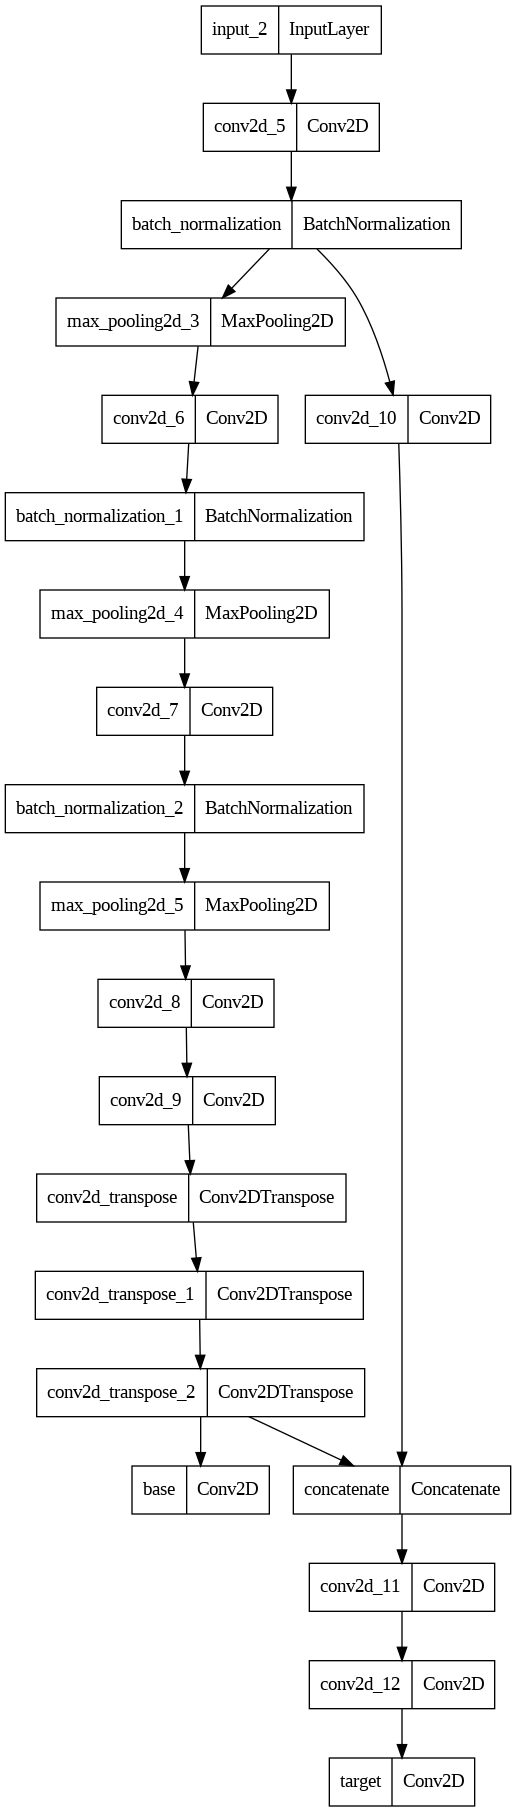

In [ ]:
utils.plot_model(Gen)

4/4 [==============================] - 5s 1s/step


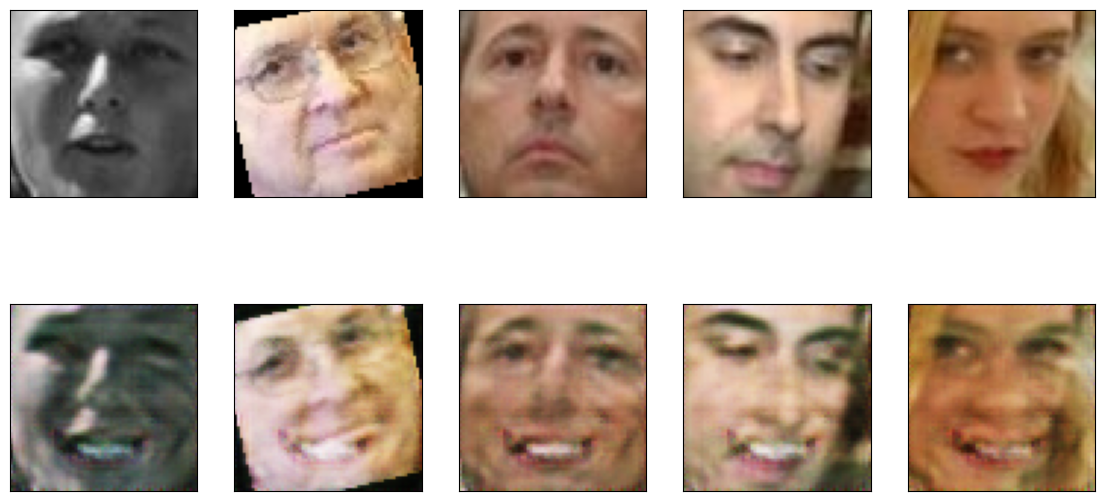

In [ ]:
nosmile = shuffle(nosmile)[:100]
p = gen2.predict(nosmile)
p = np.concatenate([p[0],p[1]])
plot_images(nosmile,p)

Можно заметить что нейросеть не только накладывает белые зубы, но и создает возмущения и натягивает щеки